# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.shape
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [4]:
df_content.shape

(1056, 5)

In [5]:
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

### Dropped null values

In [6]:
df_content_na = df_content.dropna()

In [7]:
df_content_na.shape

(1039, 5)

In [8]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [10]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [11]:
df['email']

0        ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1        083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2        b96a4f2e92d8572034b1e9b28f9ac673765cd074
3        06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4        f01220c46fc92c6e6b161b1849de11faacd7ccb2
5        b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6        3c2de1b0a92728aa53064a22ff7bd7319878ed95
7        3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8        8b6fb4bbb7a27b336ba35420bf58337d877455c7
9        35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4
10       fc4e4290f2f320d80711bbe019618cc5be8815fa
11       de6333cc934b9b7663ea38ca7cf13d59a4baae3b
12       5e8b6eea25188b0516fc111a32daa59a4419f767
13       06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
14       35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4
15       f44787ebd5330e097a1ee8aea81d970200e912bb
16       fc4e4290f2f320d80711bbe019618cc5be8815fa
17       ec123f6658890db92d7db29a04c03e5e2098fa43
18       9ac67534404850b3850c331c66e9233504ec5eaa
19       011ae4de07ffb332b0f51c155a35c23c80294962


In [12]:
df['title']

0        using pixiedust for fast, flexible, and easier...
1             healthcare python streaming application demo
2               use deep learning for image classification
3                ml optimization using cognitive assistant
4                deploy your python model as a restful api
5               visualize data with the matplotlib library
6               use deep learning for image classification
7        upload files to ibm data science experience us...
8             healthcare python streaming application demo
9                    classify tumors with machine learning
10                configuring the apache spark sql context
11       got zip code data? prep it for analytics. – ib...
12                             the unit commitment problem
13            healthcare python streaming application demo
14                apache spark lab, part 1: basic concepts
15                             getting started with python
16       timeseries data analysis of iot events by usin.

In [13]:
articles_per_user = df['email'].value_counts() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
articles_per_user

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d

In [14]:
median_value =articles_per_user.median()
print(median_value)
max_value = articles_per_user.max()
print(max_value)

3.0
364


(array([  4.72000000e+03,   2.84000000e+02,   7.80000000e+01,
          3.90000000e+01,   9.00000000e+00,   9.00000000e+00,
          7.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00]),
 array([   1. ,   25.2,   49.4,   73.6,   97.8,  122. ,  146.2,  170.4,
         194.6,  218.8,  243. ,  267.2,  291.4,  315.6,  339.8,  364. ]),
 <a list of 15 Patch objects>)

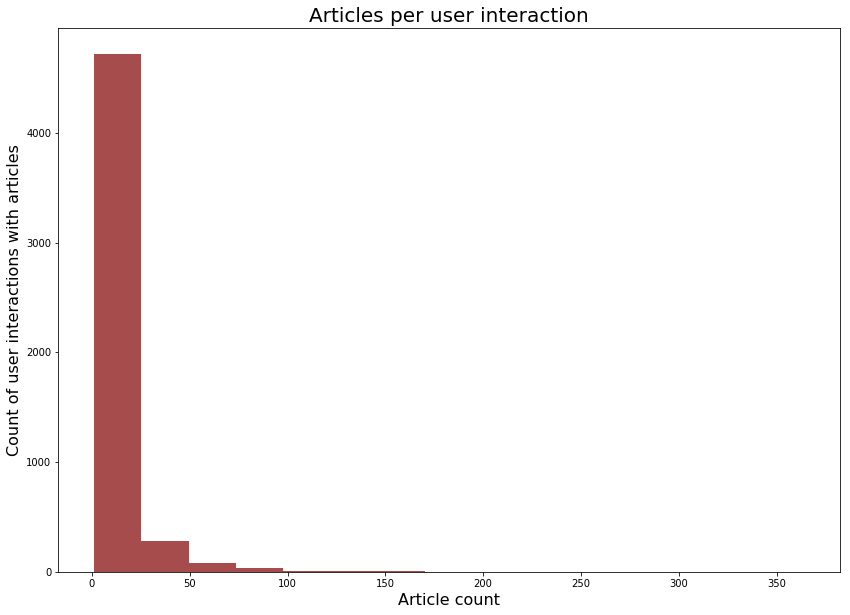

In [15]:
plt.figure(figsize=(14,10))
plt.title('Articles per user interaction',fontsize = 20)
plt.xlabel('Article count',fontsize = 16)
plt.ylabel('Count of user interactions with articles',fontsize = 16)

plt.hist(articles_per_user, bins=15,  color ='maroon', alpha =0.7) # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html


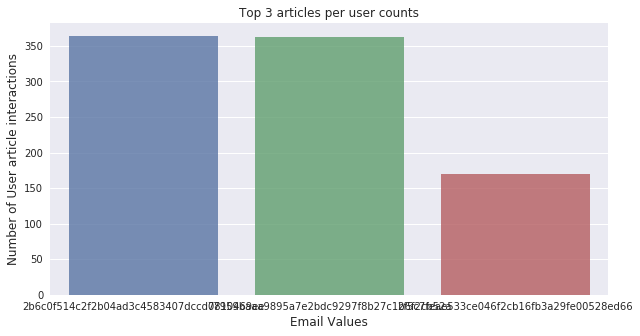

In [16]:
plt.figure(figsize=(10,5))
sns.set(style='darkgrid')

sns.barplot(articles_per_user[:3].index, articles_per_user[:3].values, alpha=0.8)
plt.title('Top 3 articles per user counts')
plt.ylabel('Number of User article interactions', fontsize=12)
plt.xlabel('Email Values', fontsize=12)

    
plt.show()

In [17]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3.0# 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
# Check duplicate articles
df_content['article_id'].duplicated().sum()

5

In [19]:
# show duplicates
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [20]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

In [21]:
# Check duplicate articles after drop duplicates
df_content['article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [22]:
# number of unique articles that have unique interaction with a user
df_content['article_id'].nunique() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html


1051

In [23]:
# number of unique articles in dataset
df['article_id'].nunique()

714

In [24]:
# The number of unique users in the dataset.
df['email'].nunique()

5148

In [25]:
# user article interactions
df.shape[0]

45993

In [26]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users =  df['email'].nunique() # The number of unique users
user_article_interactions =  df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [27]:
# Value counts of article ids
df['article_id'].value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [28]:
# Max value
df['article_id'].value_counts().max()

937

In [29]:
# The most viewed article in the dataset as a string with one value following the decimal and idmax gets most frequent
df['article_id'].value_counts().idxmax().astype(str) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html

'1429.0'

In [30]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [31]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [31]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [32]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
     n - (int) the number of top articles to return
     df - (pd.Dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
      top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # As value counts is descending by default, head will always give top n values
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nlargest.html
    top_articles = df['article_id'].value_counts().nlargest(n).index.astype(str).tolist()     #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html

    print(top_articles)
    return top_articles # Return the top article ids

In [40]:
df[df['article_id'] == 1314.0]['title'].unique().tolist()[0] 

'healthcare python streaming application demo'

In [41]:
df['article_id'].iloc[1]

1314.0

In [43]:
def get_top_articles(n, df=df):
    '''
    INPUT:
     n - (int) the number of top articles to return
     df - (pd.Dataframe) dataframe 
    
    OUTPUT:
      top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_ids = get_top_article_ids(n)
    
    df_article = df['article_id']
    top_articles = [df[df_article == float(i)]['title'].iloc[0] for i in top_ids] #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
    
    return top_articles # Return the top article titles from df (not df_content)



In [44]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [45]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0', '1436.0', '1271.0', '1398.0', '43.0', '1351.0', '1393.0', '1185.0', '1160.0', '1354.0', '1368.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0', '1436.0', '1271.0', '1398.0', '43.0', '1351.0', '1393.0', '1185.0', '1160.0', '1354.0', '1368.0']
Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [46]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Group by user_id, within each user_id we are grouping by article_id
    user_article_group = df.groupby(['user_id','article_id'])
    
    '''
    fill Nan with 0 value
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html
    '''
    user_item = user_article_group['title'].agg(lambda t: 1).unstack(fill_value=0) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [48]:
# Top 5 rows of the user item matrix
user_item.head(5)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
user_item.describe()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.008545,0.002525,0.015925,0.001942,0.019227,0.017285,0.005050,0.010876,0.013206,...,0.006992,0.014566,0.054768,0.024665,0.008351,0.001554,0.001165,0.000777,0.002331,0.000971
std,0.048224,0.092054,0.050188,0.125199,0.044031,0.137335,0.130344,0.070887,0.103729,0.114169,...,0.083331,0.119819,0.227549,0.155117,0.091011,0.039390,0.034120,0.027864,0.048224,0.031150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
user_item.dtypes

article_id
0.0       int64
2.0       int64
4.0       int64
8.0       int64
9.0       int64
12.0      int64
14.0      int64
15.0      int64
16.0      int64
18.0      int64
20.0      int64
25.0      int64
26.0      int64
28.0      int64
29.0      int64
30.0      int64
32.0      int64
33.0      int64
34.0      int64
36.0      int64
39.0      int64
40.0      int64
43.0      int64
48.0      int64
50.0      int64
51.0      int64
53.0      int64
54.0      int64
57.0      int64
58.0      int64
          ...  
1412.0    int64
1414.0    int64
1415.0    int64
1416.0    int64
1418.0    int64
1419.0    int64
1420.0    int64
1421.0    int64
1422.0    int64
1423.0    int64
1424.0    int64
1425.0    int64
1426.0    int64
1427.0    int64
1428.0    int64
1429.0    int64
1430.0    int64
1431.0    int64
1432.0    int64
1433.0    int64
1434.0    int64
1435.0    int64
1436.0    int64
1437.0    int64
1439.0    int64
1440.0    int64
1441.0    int64
1442.0    int64
1443.0    int64
1444.0    int64
Length: 714, 

In [54]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [55]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.loc[user_id].dot(user_item.T) # loc to access by label 
    
    
    # sort by similarity
    sorted_similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
                                            
    # create list of just the ids i.e. the keys
    most_similar_users = [k for (k, v) in sorted_similarity]                                    
   
    # remove the own user's id as per instructions as user is always similar to itself
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [56]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [69]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique() #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html
    return article_names # Return the article names associated with list of article ids

In [66]:
def user_user_recs(user_id, no_of_recs=10):
    '''
    INPUT:
    user_id - (int) a user id
    no_of_recs - (int) the number of recommendations you want for the user
    
    OUTPUT:
    rec_list - (list) a list of recommendations for the user
    
    Description:
    Returns a list of recommendations based on most similar users
    
    '''
    rec_list = []
    
    # find most similar users
    most_similar_users = find_similar_users(user_id)
    
    # get user articles
    the_user_articles, the_article_names = get_user_articles(user_id)
    
    
    for user in most_similar_users:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if len(rec_list) >= no_of_recs:
                break
            if id not in the_user_articles:
                rec_list.append(id)
        if len(rec_list) >= no_of_recs: 
            break
    
    if len(rec_list) < no_of_recs:
        for id in str(df['article_id']):
            if id not in the_user_articles:
                rec_list.append(id)
            if len(recs) >= no_of_recs:
                break
                    
    return rec_list # return your recommendations for this user_id    

In [70]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_access = user_item.loc[user_id] # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
    
    # article_ids list
    article_ids = user_access[user_access!=0].index.astype(str).tolist()
    
    # article_names list
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

In [71]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array([ 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'], dtype=object)

In [72]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [78]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pd.Dataframe)
                
    
    Description: Return the top sorted users
     
    '''
    # similarity dot matrix
    similarity = user_item.dot(user_item.loc[user_id])
    
    # articles read 
    articles_read = user_item.sum(axis=1)
    
    # concat the two dataframes
    neighbors_df = pd.concat([similarity, articles_read], axis=1) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    
    # assigning column labels
    neighbors_df.columns = ['similarity', 'num_interactions']
    
    # sort by similarity and num_interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # drop user_id
    neighbors_df.drop(user_id, inplace=True)
    
    # reset index
    neighbors_df.reset_index(inplace=True)
    
    # rename user_id to neighbor_id
    neighbors_df.rename(columns={'user_id':'neighbor_id'}, inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string





In [85]:
def user_user_recs_part2(user_id, no_of_recs=10):
    '''
    INPUT:
    user_id - (int) a user id
    no_of_recs - (int) the number of recommendations you want for the user
    
    OUTPUT:
    rec_list - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Returns list of recommendations and recommended artilces names
   
    '''
    # get articles read by user
    articles_read_by_user, _ = get_user_articles(user_id, user_item)
    
    # Get most similar users
    similar_users = get_top_sorted_users(user_id, df, user_item)['neighbor_id'].values
    
    # sorted articles
    sorted_articles = df['article_id'].value_counts().index.astype(str).tolist()
    
    
    rec_list = []
    
    for user in similar_users:
        
        if len(rec_list) > no_of_recs:
            break
        
        # _ is throwaway variable
        article_ids, _ = get_user_articles(user, user_item)
        
        # articles not read by user
        articles_not_read_by_user = np.setdiff1d(article_ids, articles_read_by_user)
        
        # articles to recommend
        articles_to_recommend = np.setdiff1d(articles_not_read_by_user, rec_list).tolist()
        
        # sort with key
        articles_to_recommend.sort(key=lambda s: sorted_articles.index(s))
        
        # list extend
        rec_list.extend(articles_to_recommend)
        
    rec_list = rec_list[:no_of_recs]
    
    rec_names = get_article_names(rec_list, df)
    
    return rec_list, rec_names

In [87]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids )
print("\n")
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']


The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo'
 'use deep learning for image classification'
 'analyze energy consumption in buildings'
 'putting a human face on machine learning'
 'gosales transactions for naive bayes model'
 'insights from new york car accident reports'
 'model bike sharing data with spss'
 'finding optimal locations of new store using decision optimization'
 'deep learning with tensorflow course by big data university'
 'customer demographics and sales']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [88]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].values[10] # Find the 10th most similar user to user 131

In [89]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer:** Rank based recommendations need to be used for new users as the most popular articles can be provided to the users. Collaborative filtering is not useful in such a scenario and rank based recommendations must be given preference.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [90]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [91]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [92]:
def tokenize(text):
    """Function to tokenize an article title

    INPUT:
    text - (str) string text value 
    
    
    OUTPUT:
    tokens - (list) a list of words

    
    Description:
    Tokenizes, Lemmatizes, removes short words and returns tokens

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # remove short words
    tokens = [token for token in tokens if len(token) > 3]

    return tokens

In [93]:
def create_article_content_dataframe(df=df, df_content=df_content):
    '''
    INPUT:
    df - (pd.DataFrame) dataframe to describe user interaction with the articles
    df_content - (pd.DataFrame) describe articles
    
    
    OUTPUT:
    df_total - (pd.DataFrame) dataframe contains all articles
    article_content - (pd.DataFrame)  describe the content of each articles

    
    Description:
    Returns a pandas dataframe contains all the articles with their titles 

    '''

    # Get a dataframe of the full articles
    df_1 = df[['article_id', 'title']]
    
    # Create df 
    df_2 = pd.DataFrame({'article_id': df_content['article_id'].values,
                         'title': df_content['doc_full_name']})
    
    # join the two dfs
    df_total = pd.concat([df_1, df_2], ignore_index=True)
    
    # drop duplicates at article_id subset
    df_total.drop_duplicates(subset=['article_id'], inplace=True, keep='first')
    
    # sort_values
    df_total.sort_values(by='article_id', inplace=True)
    
    # reset index
    df_total.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    X = vectorizer.fit_transform(df_total['title'].values)
    df_vector = pd.DataFrame(X.toarray()) #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

    # set vector column names
    df_vector.columns = vectorizer.get_feature_names()
    
    # concat  df_total and df_vec
    df_articles = pd.concat([df_total, df_vector], axis=1)

    return df_total, df_articles

In [94]:
df_total, df_articles = create_article_content_dataframe()

In [95]:
df_articles.head()

,article_id,title,1000,1357,1448,1854,1948,1983,1985,1990,...,xgboost,xml2,year,yolo,york,youtube,zapier,zctas,zendesk,zero
0,0.0,detect malfunctioning iot sensors with streami...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Communicating data science: A guide to present...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,"this week in data science (april 18, 2017)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,DataLayer Conference: Boost the performance of...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,analyze ny restaurant data using spark in dsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
df_articles.iloc[:, 2:]

,1000,1357,1448,1854,1948,1983,1985,1990,1995,2003,...,xgboost,xml2,year,yolo,york,youtube,zapier,zctas,zendesk,zero
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [97]:
def create_article_similarity_dataframe(df=df_articles):
    '''
    INPUT:
    df - (pd.DataFrame) dataframe to describe artciles content
 
    
    OUTPUT:
    article_similarity - (pd.DataFrame) dataframe that describe articles similarities

    
    Description:
    Return a pandas dataframe that describe the articles similarities
    using the dot product.

    '''

    # subset articles content, select all but first 2 columns
    article_content = np.array(df_articles.iloc[:, 2:])
 

    # Take the dot product to obtain a article x article matrix of similarities, that is take dot product with its transpose
    article_dot_product = article_content.dot(article_content.T)
    
    df_article_id = df_articles['article_id']

    # make a Dataframe
    article_similarity = pd.DataFrame(article_dot_product,
                                      index=df_article_id,
                                      columns=df_article_id)

    return article_similarity

In [99]:
article_similarity = create_article_similarity_dataframe()

In [101]:
article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.123927,0.0,0.030163,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.123927,1.000000,0.0,0.042864,0.047820,0.0,0.046017,0.424907,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.046723,0.022353,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.030163,0.042864,0.0,1.000000,0.044733,0.0,0.043047,0.043556,0.141583,...,0.0,0.0,0.0,0.0,0.0,0.043707,0.020910,0.0,0.0,0.0


In [102]:
article_similarity.describe()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,...,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,0.009434,0.018456,0.035167,0.009088,0.029947,0.028693,0.006941,0.015376,0.027869,0.016537,...,0.000753,0.009927,0.003024,0.000753,0.010261,0.016066,0.008862,0.002974,0.003419,0.005282
std,0.044958,0.046676,0.105287,0.046988,0.061059,0.057049,0.043190,0.039935,0.072420,0.056597,...,0.027441,0.042620,0.037612,0.027441,0.059518,0.041076,0.035721,0.034781,0.036748,0.040370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.024566,0.034727,0.000000,0.041546,0.043718,0.000000,0.033174,0.035155,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033923,0.016281,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pd.dataframe) dataframe of user interaction

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    # check if valid user id
    df_user = df[df['user_id'] == user_id]
    
    # group by article id
    df_user = df_user.groupby('article_id').count()
    
    # sort values by descending user_ids, default is ascending
    df_user.sort_values('user_id', ascending=False, inplace=True)

    # get unique article ids
    count_article = df_user['user_id'].unique()
    
    # empty list of article_ids
    article_ids = []
    
    df_user_id = df_user['user_id']
    
    for c in count_article:
        ids = df_user[df_user_id == c].index
        article_ids.append(ids.tolist())

    return article_ids

In [104]:
def make_content_recs(user_id, n=10, df_smly=article_similarity, threshold=1):
    '''
    INPUT:
    user_id - (int) a user id
    n - (int) the number of recommendations for the user
    df_smly - (pd.dataframe) dataframe that describe the articles similarities using the dot product

    OUTPUT:
    rec_list - (list) list of recommendations for the user by article id
    rec_names - (list) list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    rec_list = []

    for ids in list_ids:
        # sum of the top articles
        top_articles = article_similarity.loc[ids].sum() 
        
        # sort values in descending
        top_articles.sort_values(ascending=False, inplace=True)
        
        # take articles greater than threshold
        top_articles = top_articles[top_articles >= threshold]
        
        # take a set difference 
        article_not_recommended = np.setdiff1d(np.array(top_articles.index),np.array(rec_list))
        
        # extend adds all values to the end of the list  
        rec_list.extend(list(article_not_recommended))

        # If len of list is more than no. of recommendations
        if len(rec_list) > n:
            break

    # get the top n values of the list 
    rec_list = rec_list[:n]
    
    # get a list of article names
    rec_names = get_article_names(rec_list, df=df_total)

    return rec_list, rec_names

In [105]:
df['user_id'].tail()

45988    5146
45989    5146
45990    5147
45991    5148
45992    5149
Name: user_id, dtype: int64

**Using grouby will help and sorting by article id will give a user equivalent to the top article_id**

In [106]:
# Get user id who only has interacted with article id '1430.0'
df_1430 = df[df['article_id'] == 1430.0].groupby('user_id').count()
user_1430 = df_1430.sort_values('article_id').index[0]

# Make recomendation
make_content_recs(user_1430)

([1050.0, 146.0, 373.0, 622.0, 634.0, 910.0, 957.0, 1430.0, 1439.0],
 array(['how to use db2 warehouse on cloud in data science experience notebooks',
        'working with notebooks in dsx',
        'htmlwidgets: javascript data visualization for r',
        'working with db2 warehouse on cloud in data science experience',
        'working with ibm cloud object storage in python',
        'brunel interactive visualizations in jupyter notebooks',
        'jupyter notebooks with scala, python, or r kernels',
        'using pixiedust for fast, flexible, and easier data analysis and experimentation',
        'working with ibm cloud object storage in r'], dtype=object))

In [107]:
make_content_recs(2556) # The user id which was selected after groupBy and sorting

([1050.0, 146.0, 373.0, 622.0, 634.0, 910.0, 957.0, 1430.0, 1439.0],
 array(['how to use db2 warehouse on cloud in data science experience notebooks',
        'working with notebooks in dsx',
        'htmlwidgets: javascript data visualization for r',
        'working with db2 warehouse on cloud in data science experience',
        'working with ibm cloud object storage in python',
        'brunel interactive visualizations in jupyter notebooks',
        'jupyter notebooks with scala, python, or r kernels',
        'using pixiedust for fast, flexible, and easier data analysis and experimentation',
        'working with ibm cloud object storage in r'], dtype=object))

In [108]:
df_16 = df[df['article_id'] == 16].groupby('user_id').count()
user_16 = df_16.sort_values('article_id').index[0]

make_content_recs(user_16)

([310.0, 353.0, 2.0, 8.0, 9.0, 14.0, 16.0, 21.0, 28.0, 32.0],
 array(['this week in data science (april 18, 2017)',
        'data science bowl 2017',
        '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
        'got zip code data? prep it for analytics. – ibm watson data lab – medium',
        'higher-order logistic regression for large datasets',
        'Mapping for Data Science with PixieDust and Mapbox – IBM Watson Data Lab – Medium',
        'deep forest: towards an alternative to deep neural networks',
        "a kaggler's guide to model stacking in practice",
        'time series prediction using recurrent neural networks (lstms)',
        'sparklyr — r interface for apache spark'], dtype=object))

In [109]:
make_content_recs(3, 5)

([1429.0, 1431.0, 1343.0, 1360.0, 50.0],
 array(['graph-based machine learning', 'maximize oil company profits',
        'pixieapp for outlier detection',
        'use deep learning for image classification',
        'visualize car data with brunel'], dtype=object))

In [110]:
make_content_recs(5146, 4)

([1324.0, 142.0, 1123.0, 1124.0],
 array(['neural networks for beginners: popular types and applications',
        'airbnb data for analytics: portland calendar',
        'airbnb data for analytics: portland listings',
        'ibm watson facebook posts for 2015'], dtype=object))

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

***Answer:*** Content based recommendation works by using TfIdf for content based filtering and using a tokenizer with english words. Tfidf encoding weighs the terms according to importance in the document. The more the frequency, the higher the weight and it uses inverse frequency thus giving less priority to connecting words like is, the, an etc.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [111]:
# make recommendations for a brand new user
make_content_recs(1)
# make a recommendations for a user who only has interacted with article id '1427.0'
df_1427 = df[df['article_id'] == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

make_content_recs(user_1427)


([310.0, 585.0, 668.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0, 1431.0, 13.0],
 array(['Bridging the Gap Between Python and Scala Jupyter Notebooks',
        'time series prediction using recurrent neural networks (lstms)',
        'tidyverse practice: mapping large european cities',
        'shiny: a data scientist’s best friend', 'categorize urban density',
        'classify tumors with machine learning',
        'predict loan applicant behavior with tensorflow neural networking',
        'uci: iris',
        'using pixiedust for fast, flexible, and easier data analysis and experimentation',
        'visualize car data with brunel'], dtype=object))

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [112]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [113]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
user_item_matrix.describe()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.001748,0.002136,0.001359,0.002719,0.002331,0.015343,0.020392,0.000971,0.011070,...,0.003302,0.024665,0.023305,0.000194,0.000777,0.002331,0.005050,0.003690,0.010099,0.000777
std,0.048224,0.041776,0.046176,0.036850,0.052078,0.048224,0.122924,0.141352,0.031150,0.104641,...,0.057370,0.155117,0.150887,0.013936,0.027864,0.048224,0.070887,0.060639,0.099995,0.027864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [115]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

***Answer***: 
In the lesson, user_item_matrix had null values, so we had to use FunkSVD. SVD works fine as there are no no nulls values here. #https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

Text(0.5,1,'Accuracy vs. Number of Latent Features')

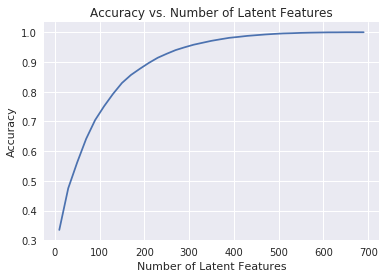

In [116]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # dot product 
    dot_product = np.dot(u_new, s_new)
    
    # take dot product
    user_item_est = np.around(np.dot(dot_product, vt_new))
    
    # compute error for each prediction to actual value
    diffs = user_item_matrix - user_item_est
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    
    # add errors to sum_errors
    sum_errs.append(err)
        
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [117]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe               
    user_item_test - a user-item matrix of the testing dataframe               
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # user_item_train
    user_item_train = create_user_item_matrix(df_train)
    
    # user_item_test
    user_item_test = create_user_item_matrix(df_test)
    
    # test_idx
    test_idx = user_item_test.index.values
    
    # test_arts
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [118]:
# User Id in both train and test set
np.intersect1d(test_idx, user_item_train.index.values).shape #https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html

(20,)

In [119]:
# User Id in test set, not in train set
np.setdiff1d(test_idx, user_item_train.index.values).shape #https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html

(662,)

In [120]:
# Article Id in both train and test set
np.intersect1d(test_arts, user_item_train.columns.values).shape #https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html

(574,)

In [121]:
# Article Id in test set, not in train set
np.setdiff1d(test_arts, user_item_train.columns.values).shape # https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html

(0,)

In [122]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [123]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape


((4487, 4487), (714,), (714, 714))

In [124]:
rows = user_item_train.index.isin(test_idx)
cols = user_item_train.columns.isin(test_arts)
u_test = u_train[rows, :]
vt_test = vt_train[:, cols]
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [125]:
# Keep only the rows and columns in test data, which are also present in train data
idx_list = np.intersect1d(test_idx, user_item_train.index.values)

col_list = np.intersect1d(test_arts, user_item_train.columns.values)

user_item_test = user_item_test.loc[idx_list, col_list] # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html

user_item_test.shape


(20, 574)

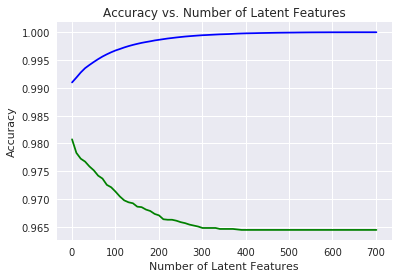

In [126]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(1, 700+10, 10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_predictions_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_predictions_test = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_predictions_train)
    diffs_test = np.subtract(user_item_test, user_item_predictions_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train) # append to train errors
    sum_errs_test.append(err_test) # append to sum errors
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train', c = 'b');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test', c = 'g');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

***Answer:*** The matrix factorization method gives very high accuracy. This is likely because of the large class imbalance of 0s and 1s in the user-item matrix, since each user reads only a few articles. Also, we tested for only 20 users, the rest of 662 users in the test set are new users, and the above matrix factorization method doesn't work for new users.  The predictive accuracy is relatively highly because the matrix is not that dense. So, even though the accuracy score is pretty high, we can't really say that our recommendation system is doing a great job as it accounts for a very small sample size.
To determine if our system is actually making good recommendations, we need to perform an A/B test experiment.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [127]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0